<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Numerical methods:  8. Optimisation
## Linear fit with functions
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.optimize

import numerics.change_fonts; numerics.change_fonts.change_fontsize()

## Load and plot test data

The test data set are **beach lines** from Richmond Gulf, an area along the shores of Hudson Bay in Canada.

We load the data set with the `csv` package:

In [2]:
csvfile = open('data/fit_richmondgulf.in', newline='')
beachlines = csv.reader(csvfile)
next(beachlines)
i=0
tobs=np.array([])
terr=np.array([])
hobs=np.array([])
herr=np.array([])
for row in beachlines:
    #print (row[0].split())
    tobs = np.append(tobs,float(row[0].split()[0]))
    terr = np.append(terr,float(row[0].split()[1]))
    hobs = np.append(hobs,float(row[0].split()[2]))
    herr = np.append(herr,float(row[0].split()[3]))
    i=i+1

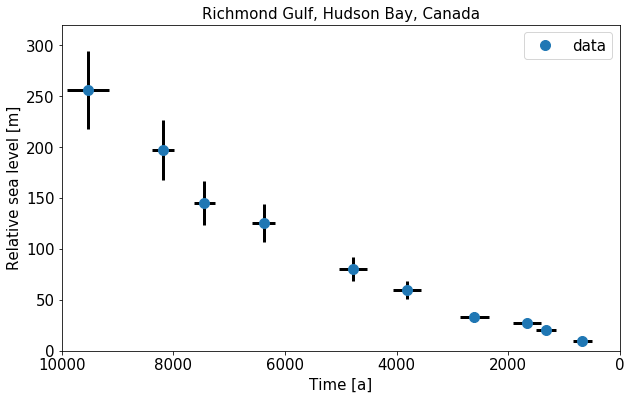

In [3]:
plt.figure(figsize=(10,6))
plt.title('Richmond Gulf, Hudson Bay, Canada')
plt.xlim([10000,0])
plt.ylim([0,320])
plt.xlabel('Time [a]')
plt.ylabel('Relative sea level [m]')
plt.errorbar(tobs,hobs,xerr=terr,yerr=herr,linewidth=0,elinewidth=3,ecolor='black')
plt.plot(tobs,hobs,linewidth=0,marker='o',markersize=10,label='data')
plt.legend()

----
## Fit with linear functions

As a second case, we define a **set of functions with linear coefficients** to fit our data points. 
We therefore define the **predictions** $p_i$ as
$$
p_i(a_j) = \sum\limits_{j=1}^{m} a_j X_j(x_i)
$$
with $X_j(a_i)$ a set of base functions.

Inserting this prediction function into the **least-squares fit**
$$
\chi^2 = \sum\limits_{i=1}^{n} \left( \frac{o_i - p_i}{\sigma_i} \right)^2
$$
yields:
$$
\chi^2 = \sum\limits_{i=1}^{n} \left( \frac{o_i - \sum\limits_{j=1}^{m} a_j X_j(a_i)}{\sigma_i} \right)^2
$$

We find the **best fit** by minimising $\chi^2$ with respect to the **model parameter vector**
$a_j$, and setting the partial derivates to zero (see lecture).

$$
\begin{array}{rcl}
 \alpha_{kj} a_j & = & \beta_k \\
 \alpha_{kj}     & = & \sum\limits_{i=1}^{n} \frac{X_j(x_i) X_k(x_i)}{\sigma_i^2} \\
 \beta_k         & = & \sum\limits_{i=1}^{n} \frac{o_i X_k(x_i)}{\sigma_i^2}
\end{array}
$$

Take, as an example, the base functions to be a polynomial:
$$
\begin{array}{rcl}
X_1(x) &=& 1 \\
X_2(x) &=& x \\
X_3(x) &=& x^2 \\
X_4(x) &=& x^3
\end{array}
$$
defined as function `f_poly`, results in the prediction function
$$
p_i(a_j) = a_0 + a_1 x + a_2 x^2 + a_3 x^3
$$

In [4]:
def f_poly(i,x):
    y = x**i
    return y

To solve the system of equations $\alpha_{kj} a_j = \beta_k$, we need our tools from the chapter linear system of equations.

In [5]:
def lin_lu_decompose(a):
    '''
    #----------------------------------------------------------------------
    # subroutine decomposes matrix A 
    # into lower L and upper U triangular matrices, using LU decompostion
    # Input:
    # a(n,n)  - coefficient matrix
    # Output:
    # l(n,n)  - lower triangular matrix
    # u(n,n)  - upper triangular matrix
    # (c) Georg Kaufmann
    #----------------------------------------------------------------------
    '''
    n = a.shape[0]
    l = np.zeros([n,n])
    u = np.zeros([n,n])
    for j in np.arange(1,n+1): # 1,n
        l[j-1][j-1] = 1.
        u[1-1][j-1] = a[1-1][j-1]
        l[j-1][1-1] = a[j-1][1-1] / u[1-1][1-1]
    for i in np.arange(2,n+1): # 2,n
        sum = 0.
        for k in np.arange(1,i): # 1,i-1
            sum = sum + l[i-1][k-1]*u[k-1][i-1]
        u[i-1][i-1] = a[i-1][i-1] - sum
        for j in np.arange(i+1,n+1): # i+1,n
            sum = 0.
            for k in np.arange(1,i): # 1,i-1
                sum = sum + l[i-1][k-1]*u[k-1][j-1]
            u[i-1][j-1] = (a[i-1][j-1] -  sum) / l[i-1][i-1]
            sum = 0.
            for k in np.arange(1,i): # 1,i-1
                sum = sum + l[j-1][k-1]*u[k-1][i-1]
            l[j-1][i-1] = (a[j-1][i-1] - sum) / u[i-1][i-1]
    return l,u

In [6]:
def lin_lu_solve(l,u,b):
    '''
    #----------------------------------------------------------------------
    # subroutine solves the system of linear equations
    # a(n,n)*x(n) = b(n)
    # using the lower and upper triangular matrices L and U
    # obtained from LU decomposition
    # Input:
    # a(n,n)  - coefficient matrix
    # b(n)    - rhs vector
    # Output:
    # x(n)    - solution vector
    # (c) Georg Kaufmann
    #----------------------------------------------------------------------
    '''
    n = len(b)
    # solve decomposed system Ly=b with forward substitution
    for i in np.arange(1,n+1): # 1,n
        sum = 0.
        for j in np.arange(1,i): # 1,i-1
            sum = sum + l[i-1][j-1] * b[j-1]
        b[i-1] = (b[i-1] - sum) / l[i-1][i-1]
    # solve decomposed system Ux=y with backward substitution
    x = np.zeros([n])
    for i in np.arange(n-1,-1,step=-1): # n,1,-1
        sum = 0.0
        for j in np.arange(i+1,n): # i+1,n
            sum = sum + u[i][j] * x[j]
        x[i] = (b[i] - sum) / u[i][i]
    return x

In [7]:
def fit_linear_function(f,x,y,yerr,m=4):
    n = len(x)
    alpha = np.zeros(m*m).reshape(m,m)
    beta  = np.zeros(m)
    # fill design matrix and rhs vector
    for j in range(m):
        for k in range(m):
            for i in range(n):    
                alpha[k,j] = alpha[k,j] + f(j,x[i])*f(k,x[i])/yerr[i]**2

    for k in range(m):
        for i in range(n):
            beta[k] = beta[k] + y[i]*f(k,x[i])/yerr[i]**2
    # solve system with LU decomposition
    l,u = lin_lu_decompose(alpha)
    a = lin_lu_solve(l,u,beta)
    # chi2 value
    chi2  = 0.
    for i in range(n):
        model = 0.
        for j in range(m):
            model = model + a[j]*f(j,x[i])
        chi2 = chi2 + ((y[i]-model)**2 / yerr[i]**2)
    return a,chi2

In [20]:
m=4
a,chi2 = fit_linear_function(f_poly,tobs,hobs,herr,m)

In [21]:
print(a,chi2)

[ 1.37068322e-01  1.55163117e-02 -1.00395490e-06  2.33614283e-10] 2.1553174187162143


In [22]:
n = len(tobs)
hpred = np.zeros(n)
for i in range(n):
    for j in range(m):
        hpred[i] = hpred[i] + a[j]*f_poly(j,tobs[i])

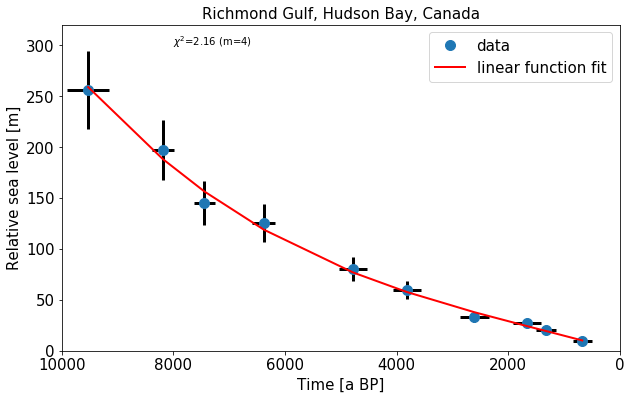

In [23]:
plt.figure(figsize=(10,6))
plt.title('Richmond Gulf, Hudson Bay, Canada')
plt.xlim([10000,0])
plt.ylim([0,320])
plt.xlabel('Time [a BP]')
plt.ylabel('Relative sea level [m]')
plt.errorbar(tobs,hobs,xerr=terr,yerr=herr,linewidth=0,elinewidth=3,ecolor='black')
plt.plot(tobs,hobs,linewidth=0,marker='o',markersize=10,label='data')
plt.plot(tobs,hpred,linewidth=2,color='red',label='linear function fit')
plt.text(8000.,300.,'$\chi^2$='+str(round(chi2,2))+' (m='+str(m)+')')
plt.legend(loc='best')

----
[next>](Numerics_lab08_nonlinear_functions.ipynb)